## BPSK Filter

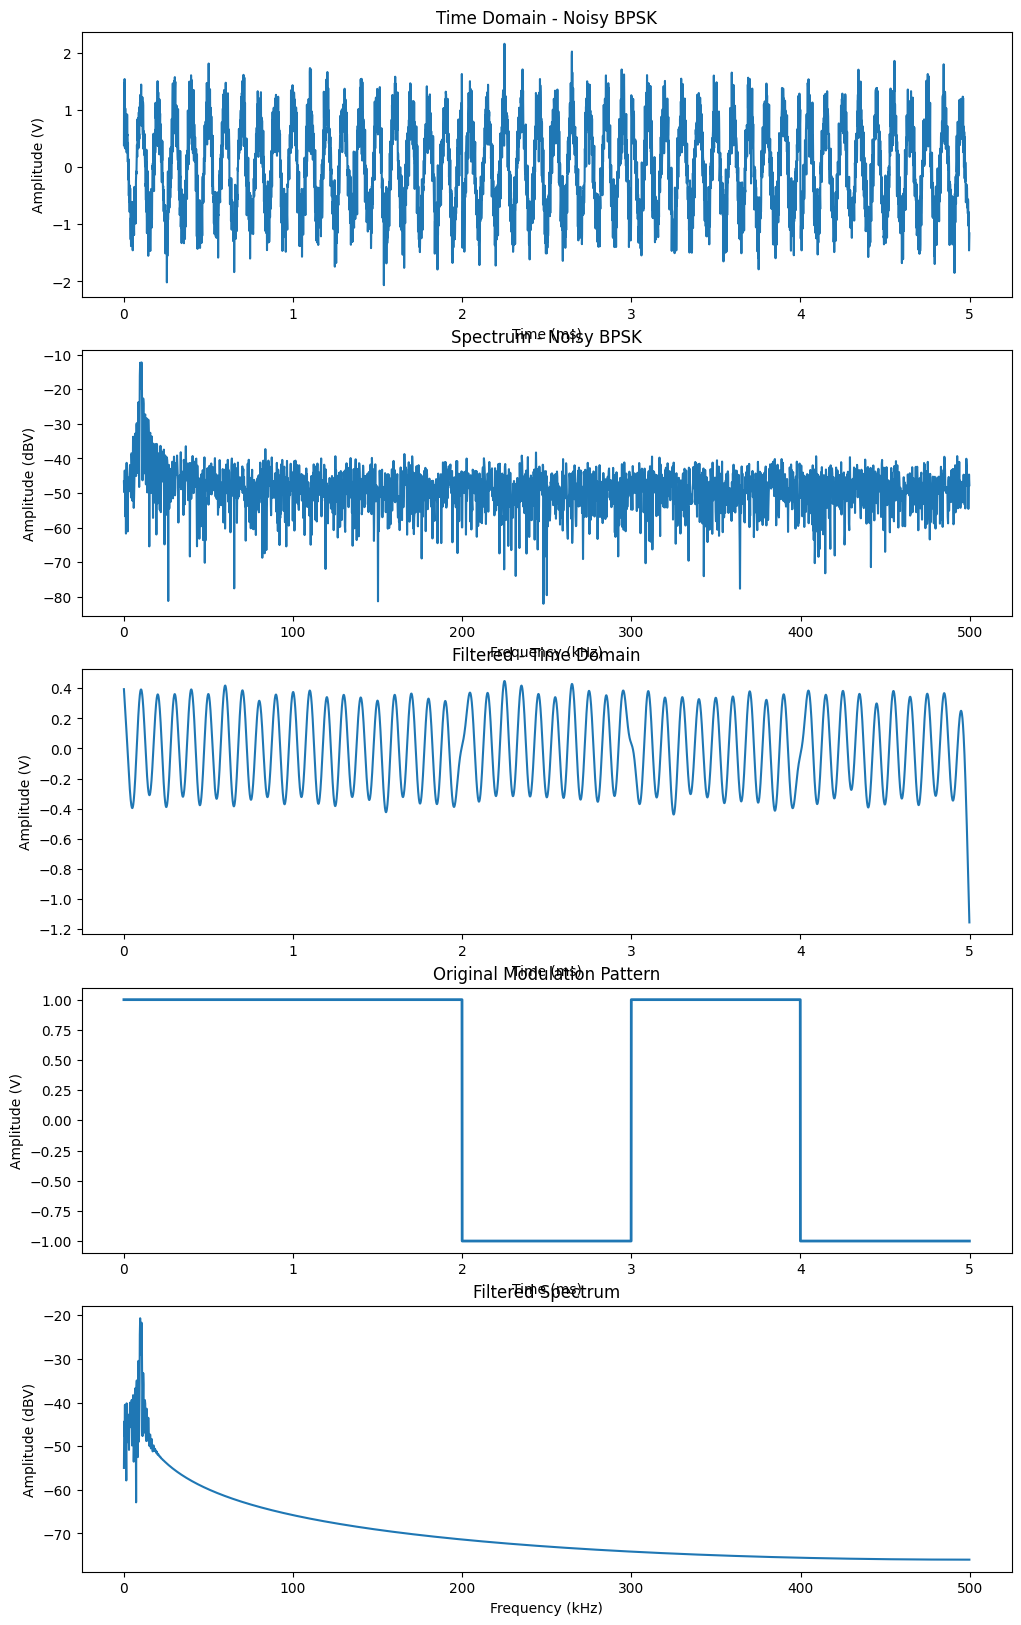

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, firwin, freqz
from scipy.fft import fft
from numpy.random import normal

# Time base parameters
dt = 1e-6              # Time scale: 1us
fs = 1/dt              # Sampling frequency: 1Mhz
stop = 5e-3            # Stop time: 5ms
t = np.arange(0, stop, dt)   # Discrete time vector
N = len(t)             # Points
fv = np.arange(0, N//2) * fs / N  # Discrete frequency vector

# BPSK pulse
A = 1                  # Amplitude: 1V
fc = 10e3              # Carrier frequency: 10kHz
Rb = 1e3               # Baudrate: 1kbps
code = '1101010001'

# Calculate number of samples per bit
samples_per_bit = int(fs / Rb)

bpsk = np.zeros(N)
mod = np.zeros(N)

# Ensure the generated BPSK signal does not exceed the array length
for i, bit in enumerate(code):
    start = i * samples_per_bit
    end = start + samples_per_bit
    if end > N:  # Ensure we do not exceed the length of the array
        end = N
    t_cell = t[start:end]
    if bit == '0':
        bpsk[start:end] = -np.cos(2 * np.pi * fc * t_cell)
        mod[start:end] = -1
    else:
        bpsk[start:end] = np.cos(2 * np.pi * fc * t_cell)
        mod[start:end] = 1

s = 20 * np.log10(np.abs(fft(bpsk)) / N)

# Gaussian distributed random noise
bw = 1e3               # Bandwidth
k = 0.0001             # Power spectral density
grn = normal(0, np.sqrt(k*bw), N)

bpsk_n = bpsk + grn
s_n = 20 * np.log10(np.abs(fft(bpsk_n)) / N)

# FIR LowPass Filter Design
numtaps = 101          # Number of taps in the FIR filter
cutoff = 10e3 / (fs/2) # Normalized cutoff frequency
fir_coeff = firwin(numtaps, cutoff)

# Apply FIR Filter to noise signal and compensate for delay
bpsk_n_f = filtfilt(fir_coeff, [1], bpsk_n)
s_n_f = 20 * np.log10(np.abs(fft(bpsk_n_f)) / N)

# Plotting
plt.figure(figsize=(12, 20))
plt.subplot(5, 1, 1)
plt.plot(t * 1000, bpsk_n)
plt.title('Time Domain - Noisy BPSK')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

plt.subplot(5, 1, 2)
plt.plot(fv / 1000, s_n[:N//2])
plt.title('Spectrum - Noisy BPSK')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude (dBV)')

plt.subplot(5, 1, 3)
plt.plot(t * 1000, bpsk_n_f)
plt.title('Filtered - Time Domain')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

plt.subplot(5, 1, 4)
plt.plot(t * 1000, mod, linewidth=2)
plt.title('Original Modulation Pattern')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

plt.subplot(5, 1, 5)
plt.plot(fv / 1000, s_n_f[:N//2])
plt.title('Filtered Spectrum')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude (dBV)')

plt.show()

# Calculate Signal to Noise Ratio
r_origin = 20 * np.log10(np.linalg.norm(bpsk) / np.linalg.norm(bpsk - bpsk_n))
r_filtered = 20 * np.log10(np.linalg.norm(bpsk) / np.linalg.norm(bpsk - bpsk_n_f))

## BPSK Wavelet

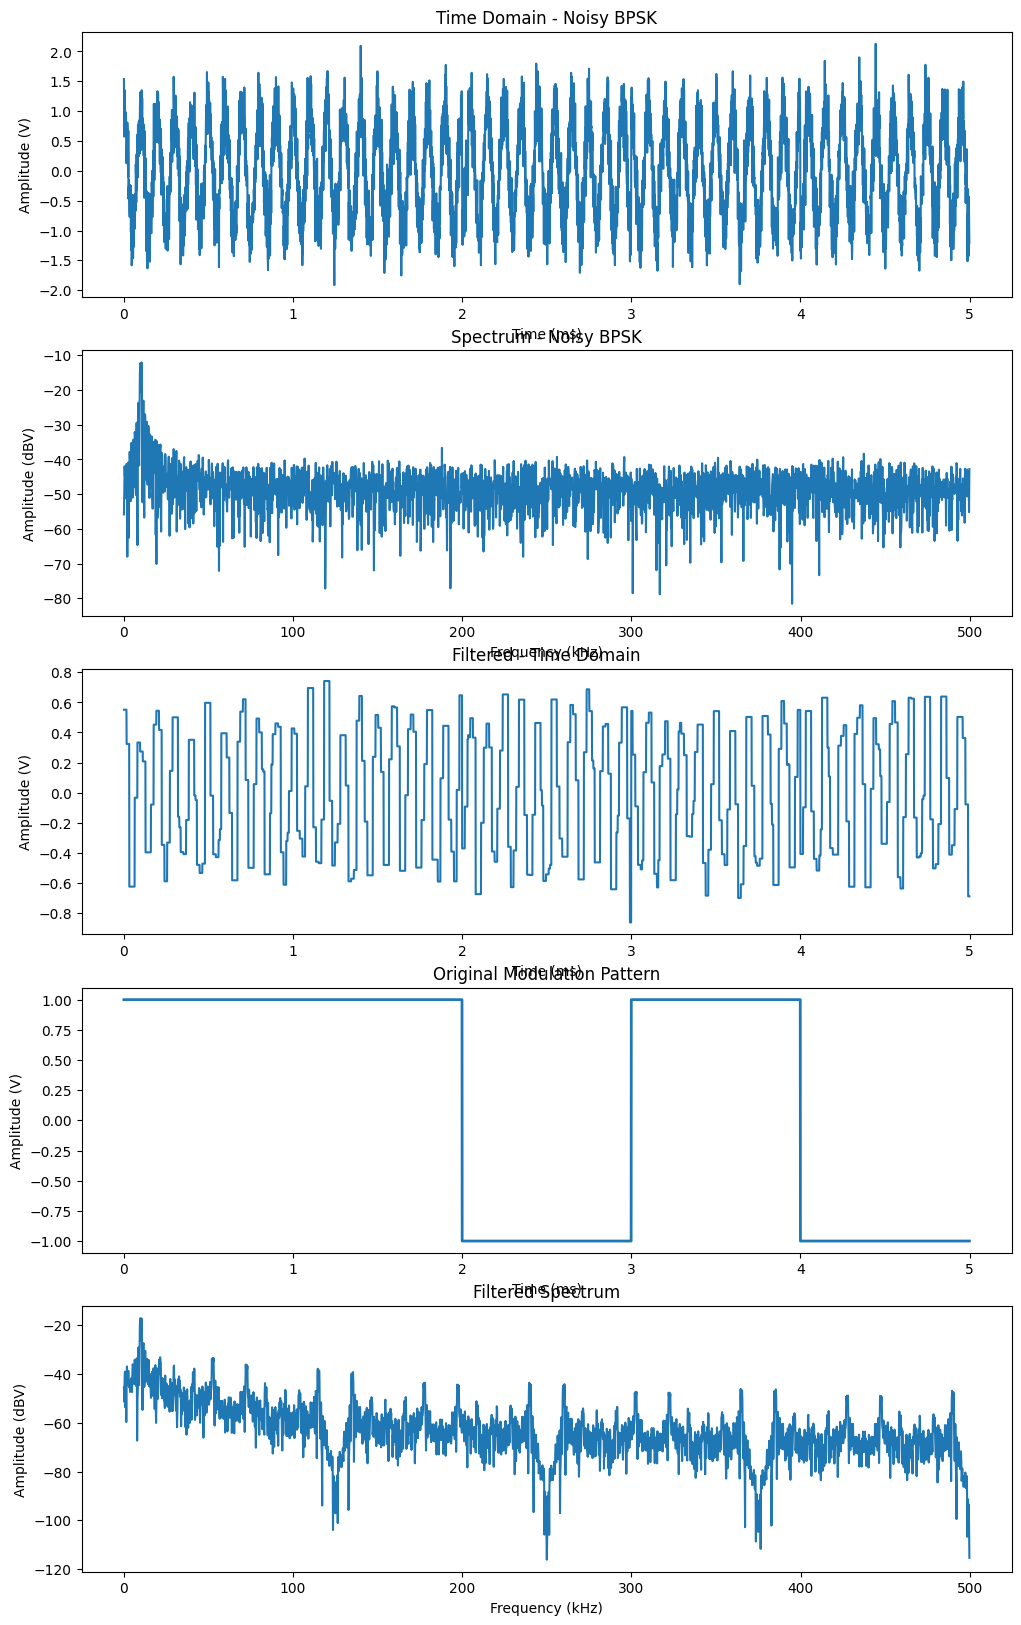

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import butter, filtfilt
import pywt

# Time base parameters
dt = 1e-6              # Time scale: 1us
fs = 1/dt              # Sampling frequency: 1Mhz
stop = 5e-3            # Stop time: 5ms
t = np.arange(0, stop, dt)   # Discrete time vector
N = len(t)             # Points
fv = np.arange(0, N//2) * fs / N  # Discrete frequency vector

# BPSK pulse
A = 1                  # Amplitude: 1V
fc = 10e3              # Carrier frequency: 10kHz
Rb = 1e3               # Baudrate: 1kbps
code = '1101010001'

samples_per_bit = int(fs / Rb)  # Number of samples per bit
bpsk = np.zeros(N)
mod = np.zeros(N)

# Ensure each bit is represented exactly by samples_per_bit
for i, bit in enumerate(code):
    start = i * samples_per_bit
    end = min(start + samples_per_bit, N)
    length = end - start
    if length > 0:  # Ensure that the segment length is positive
        t_cell = np.linspace(0, length * dt, length, endpoint=False)
        cellp = np.cos(2 * np.pi * fc * t_cell)
        celln = -cellp
        if bit == '0':
            bpsk[start:end] = celln
            mod[start:end] = -1
        else:
            bpsk[start:end] = cellp
            mod[start:end] = 1

# Add Gaussian noise
bw = 1e3
k = 0.0001
grn = normal(0, np.sqrt(k * bw), N)
bpsk_n = bpsk + grn

# Wavelet denoising
coeffs = pywt.wavedec(bpsk_n, 'db1', level=9)
sigma = np.median(np.abs(coeffs[-1] - np.median(coeffs[-1]))) / 0.6745
threshold = sigma * np.sqrt(2 * np.log(len(bpsk_n)))
bpsk_n_f = pywt.waverec([pywt.threshold(c, value=threshold, mode='soft') for c in coeffs], 'db1')

# Compute spectra
s_n = 20 * np.log10(np.abs(fft(bpsk_n)[:N//2]) / N)
s_n_f = 20 * np.log10(np.abs(fft(bpsk_n_f)[:N//2]) / N)

# Plotting
plt.figure(figsize=(12, 20))
plt.subplot(5, 1, 1)
plt.plot(t * 1000, bpsk_n)
plt.title('Time Domain - Noisy BPSK')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

plt.subplot(5, 1, 2)
plt.plot(fv / 1000, s_n)
plt.title('Spectrum - Noisy BPSK')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude (dBV)')

plt.subplot(5, 1, 3)
plt.plot(t * 1000, bpsk_n_f)
plt.title('Filtered - Time Domain')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

plt.subplot(5, 1, 4)
plt.plot(t * 1000, mod, linewidth=2)
plt.title('Original Modulation Pattern')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

plt.subplot(5, 1, 5)
plt.plot(fv / 1000, s_n_f)
plt.title('Filtered Spectrum')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude (dBV)')

plt.show()

## LFM Filter

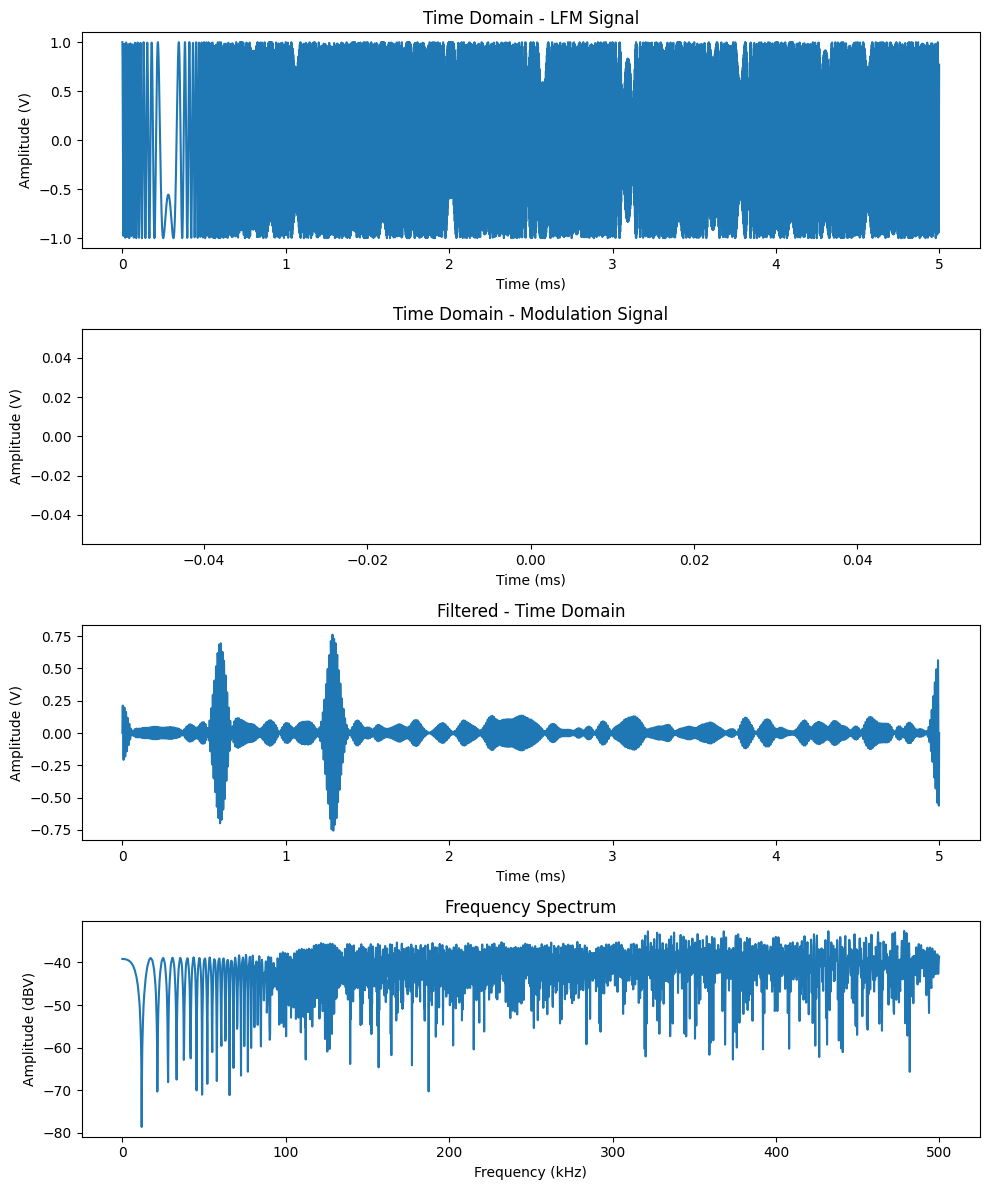

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import square, sawtooth, butter, filtfilt, firwin, freqz, lfilter
from scipy.fft import fft
from numpy.random import normal

# Time base parameters
dt = 1e-6              # Time scale: 1us
fs = 1/dt              # Sampling frequency: 1Mhz
stop = 5e-3            # Stop time: 5ms
t = np.arange(0, stop, dt)   # Discrete time vector
N = len(t)             # Points
fv = np.arange(0, N//2) * fs / N  # Discrete frequency vector

# Linear FM pulse
A = 1                  # Amplitude: 1V
f0 = 10e3              # Carrier frequency: 10kHz
fshift = 100e3         # Frequency shift: 100kHz
fm = 0.4e3             # Modulation frequency: 40Hz

# Modulation
mod = (0.5 * square(2 * np.pi * fm * t, duty=50) + 0.5) * (2 * sawtooth(2 * np.pi * fm * t, width=0.5) + 1)
# Frequency sweep
f = f0 + fshift * sawtooth(2 * np.pi * fm * t, width=0.5)
lfm = A * np.cos(2 * np.pi * f * t)
s = 20 * np.log10(np.abs(fft(lfm)[:N//2]) / N)

# Plotting time domain and spectrum
plt.figure(figsize=(10, 12))
plt.subplot(4, 1, 1)
plt.plot(t * 1000, lfm)
plt.title('Time Domain - LFM Signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

plt.subplot(4, 1, 2)
plt.plot(t * 1000, mod)
plt.title('Time Domain - Modulation Signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

# Frequency domain representation
plt.subplot(4, 1, 4)
plt.plot(fv / 1000, s)
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude (dBV)')

# Adding Gaussian noise
bw = 1e3               # Bandwidth
k = 0.0001             # Power spectral density
grn = normal(0, np.sqrt(k * bw), N)
lfm_n = lfm + grn
s_n = 20 * np.log10(np.abs(fft(lfm_n)[:N//2]) / N)

# FIR LowPass Filter Design
numtaps = 101
Fpass = 100e3 / (fs/2)
Fstop = 105e3 / (fs/2)
fir_coeff = firwin(numtaps, [Fpass, Fstop], pass_zero=False)
lfm_n_f = filtfilt(fir_coeff, [1], lfm_n)
s_n_f = 20 * np.log10(np.abs(fft(lfm_n_f)[:N//2]) / N)

# Display filtered outputs
plt.subplot(4, 1, 3)
plt.plot(t * 1000, lfm_n_f)
plt.title('Filtered - Time Domain')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

plt.tight_layout()
plt.show()

## LFM Wavelet

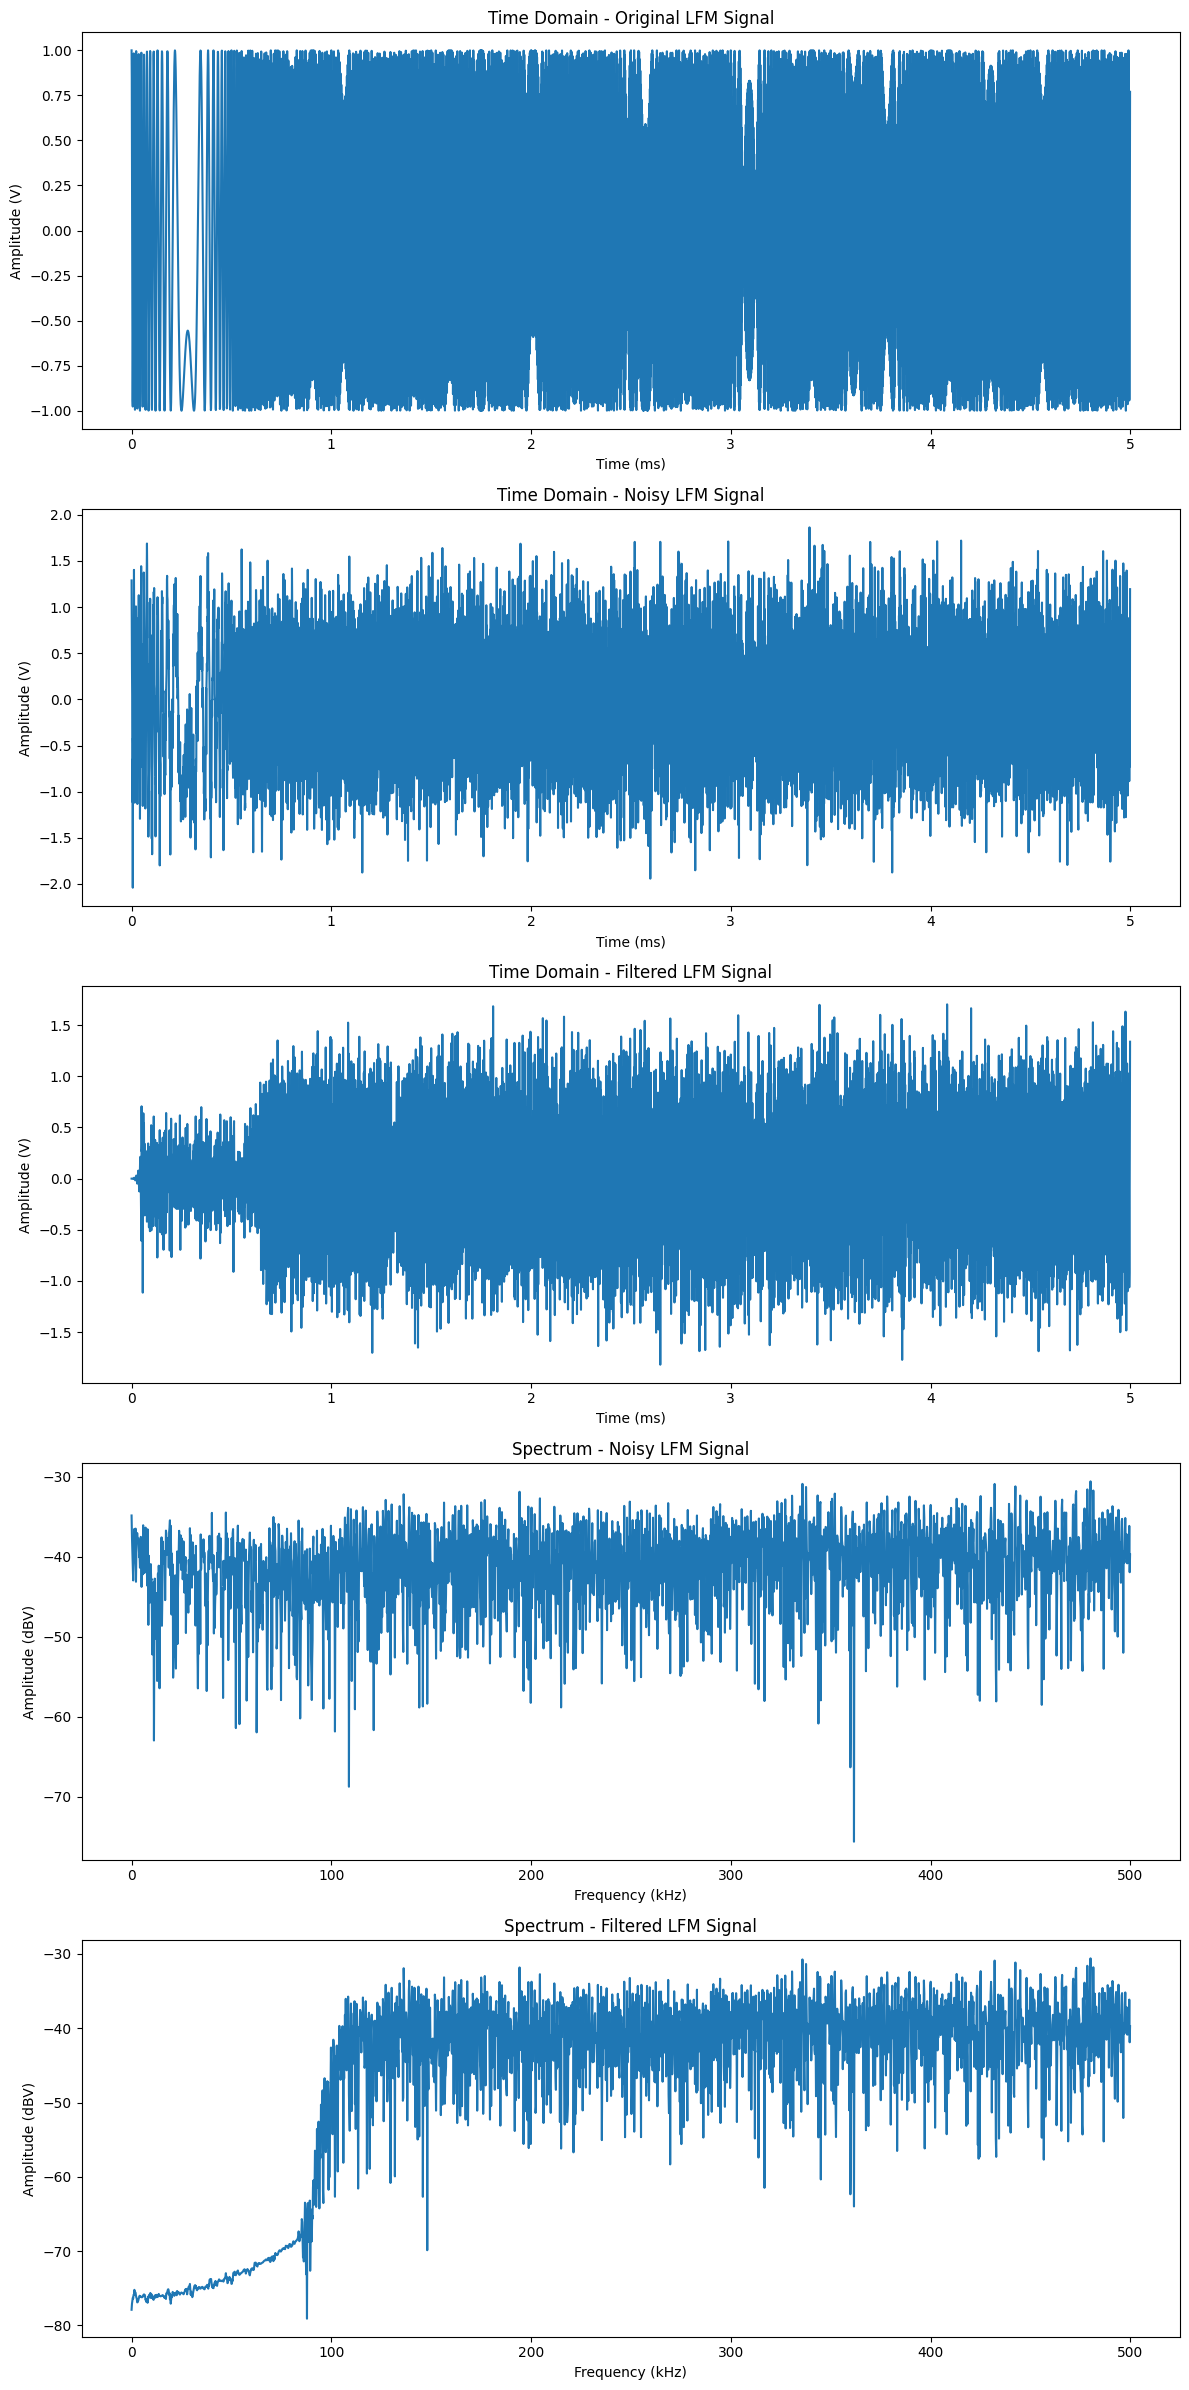

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import square, sawtooth, firwin, lfilter, spectrogram, freqz
from scipy.fft import fft
from numpy.random import normal

# Time base parameters
dt = 1e-6              # Time scale: 1us
fs = 1/dt              # Sampling frequency: 1Mhz
stop = 5e-3            # Stop time: 5ms
t = np.arange(0, stop, dt)  # Discrete time vector
N = len(t)             # Points
fv = np.arange(0, N//2) * fs / N  # Discrete frequency vector

# Linear FM pulse
A = 1                  # Amplitude: 1V
f0 = 10e3              # Carrier frequency: 10kHz
fshift = 100e3         # Frequency shift: 100kHz
fm = 0.4e3             # Modulation frequency: 40Hz

# Modulation and LFM signal
mod = (0.5 * square(2 * np.pi * fm * t, duty=0.5) + 0.5) * (2 * sawtooth(2 * np.pi * fm * t, width=0.5) + 1)
f = f0 + fshift * sawtooth(2 * np.pi * fm * t, width=0.5)
lfm = A * np.cos(2 * np.pi * f * t)
s = 20 * np.log10(np.abs(fft(lfm)[:N//2]) / N)

# Adding Gaussian noise
bw = 1e3               # Bandwidth
k = 0.0001             # Power spectral density
grn = normal(0, np.sqrt(k * bw), N)
lfm_n = lfm + grn
s_n = 20 * np.log10(np.abs(fft(lfm_n)[:N//2]) / N)

# FIR LowPass Filter Design 
Fpass = 100e3
Fstop = 105e3
numtaps = 101          # Number of taps in the FIR filter
fir_coeff = firwin(numtaps, [Fpass/(fs/2)], pass_zero=False)
lfm_n_f = lfilter(fir_coeff, [1], lfm_n)
s_n_f = 20 * np.log10(np.abs(fft(lfm_n_f)[:N//2]) / N)

# Plotting time domain and spectrum of the original, noisy, and filtered signals
plt.figure(figsize=(12, 24))
plt.subplot(5, 1, 1)
plt.plot(t * 1000, lfm)
plt.title('Time Domain - Original LFM Signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

plt.subplot(5, 1, 2)
plt.plot(t * 1000, lfm_n)
plt.title('Time Domain - Noisy LFM Signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

plt.subplot(5, 1, 3)
plt.plot(t * 1000, lfm_n_f)
plt.title('Time Domain - Filtered LFM Signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

plt.subplot(5, 1, 4)
plt.plot(fv / 1000, s_n)
plt.title('Spectrum - Noisy LFM Signal')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude (dBV)')

plt.subplot(5, 1, 5)
plt.plot(fv / 1000, s_n_f)
plt.title('Spectrum - Filtered LFM Signal')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude (dBV)')

plt.tight_layout()
plt.show()